In [70]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [71]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="",
                        port="5432")
conn.autocommit = True

In [72]:
def pullawsdata2(tablename):
    pdict = {"rally":{"query":"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;", \
             "cols":['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']}, \
    "team":{"query":"SELECT team_id,team_nm FROM pklm_prd.team;", \
             "cols": ['team_id','team_nm']}, \
    "game":{"query":"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl,vod_url FROM pklm_prd.game;", \
             "cols":['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl','vod_url']}}
    qry = pdict[tablename]["query"]
    cls = pdict[tablename]["cols"]
    
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(qry)
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cls))
        except Exception as inst:
            print(f"inst \t type: {type(inst)} \t args: {inst.args}\n")     

In [73]:
def pullrally():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [74]:
def pullgame():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl FROM pklm_prd.game;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [75]:
def pullteam():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT team_id,team_nm FROM pklm_prd.team;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['team_id','team_nm']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [76]:
rally=pullrally()
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [77]:
rally

,game_id,rally_id,rally_nbr,srv_team_id,w_team_id,to_team_id
0,1,1,1,T1,T2,N/A
1,1,2,2,T2,T2,N/A
2,1,3,3,T2,T2,N/A
3,1,4,4,T2,T2,N/A
4,1,5,5,T2,T1,N/A
...,...,...,...,...,...,...
38089,934,39826,33,T638,T638,N/A
38090,934,39827,34,T638,T727,N/A
38091,934,39828,35,T638,T638,N/A
38092,934,39829,36,T638,T727,N/A


In [78]:
print(f"Total Games = {len(game)}")
print(f"Total Rallies = {len(rally)}")
print(f"Timeouts = {len(rally[rally.to_team_id != 'N/A'])}")
print(f"\n\tGames featuring Timeout = {len(rally[rally.to_team_id != 'N/A'].game_id.unique())}")
print(f"\tRallies within Games featuring Timeout {len(rally[rally.game_id.isin(to_games)])}")

Total Games = 888
Total Rallies = 38094
Timeouts = 428

	Games featuring Timeout = 269
	Rallies within Games featuring Timeout 12366


In [79]:
428/269
428/888

0.481981981981982

In [80]:
269/888

0.30292792792792794

In [81]:
to_games = rally[rally.to_team_id != 'N/A'].game_id.unique()

In [82]:
len(rally[rally.game_id.isin(to_games)])

12366

In [83]:
game=pullgame()
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '4'] = '4.0'
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [84]:
len(played.game_id.unique())

887

In [85]:
len(rally.query('to_team_id != "N/A"').game_id.unique())

269

In [86]:
played = rally.query('to_team_id == "N/A"')
srv_win = round(100*len(played[played.srv_team_id == played.w_team_id])/len(played),2)
ret_win = round(100*len(played[played.srv_team_id != played.w_team_id])/len(played),2)
print(f'serving team wins {srv_win}% of the {len(played)} rallies')
print(f'returning team wins {ret_win}% of the {len(played)} rallies')

serving team wins 42.97% of the 37666 rallies
returning team wins 57.03% of the 37666 rallies


In [87]:
skills = sorted(list(game.skill_lvl.unique()))

In [88]:
skills

['', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', 'Pro', 'Senior Pro']

In [89]:
dskill = {}
for sk in skills:
    print(f"skill = {sk}")
    skillgame = game[game['skill_lvl'] == sk]['game_id']
    skillrally = rally.loc[rally.game_id.isin(skillgame)][lambda x:x.to_team_id == "N/A"]
    print(f"\t# games at skill = {len(skillgame)}")
    print(f"\t# rallies at skill = {len(skillrally)}")
    srv_win_skill = round(100*len(skillrally[skillrally.srv_team_id == skillrally.w_team_id])/len(skillrally),2)
    ret_win_skill = round(100*len(skillrally[skillrally.srv_team_id != skillrally.w_team_id])/len(skillrally),2)
    print(f'\n\t\tserving team wins {srv_win_skill}% of the {len(skillrally)} rallies')
    print(f'\t\treturning team wins {ret_win_skill}% of the {len(skillrally)} rallies\n\n')
    dskill[sk] = {"srv":srv_win_skill,"ret":ret_win_skill}

skill = 
	# games at skill = 1
	# rallies at skill = 19

		serving team wins 73.68% of the 19 rallies
		returning team wins 26.32% of the 19 rallies


skill = 2.5
	# games at skill = 7
	# rallies at skill = 213

		serving team wins 50.7% of the 213 rallies
		returning team wins 49.3% of the 213 rallies


skill = 3.0
	# games at skill = 18
	# rallies at skill = 703

		serving team wins 45.66% of the 703 rallies
		returning team wins 54.34% of the 703 rallies


skill = 3.5
	# games at skill = 66
	# rallies at skill = 2750

		serving team wins 42.69% of the 2750 rallies
		returning team wins 57.31% of the 2750 rallies


skill = 4.0
	# games at skill = 270
	# rallies at skill = 11818

		serving team wins 41.8% of the 11818 rallies
		returning team wins 58.2% of the 11818 rallies


skill = 4.5
	# games at skill = 103
	# rallies at skill = 4219

		serving team wins 44.84% of the 4219 rallies
		returning team wins 55.16% of the 4219 rallies


skill = 5.0
	# games at skill = 131
	# rallies at 

In [90]:
50/ret_win

0.8767315448009819

winpct - retpct*(1-50/ret_win)

In [91]:
for x in [0,.25,.5,.75,1]:
    print(x-(1-(50/ret_win)))

-0.12326845519901808
0.12673154480098192
0.3767315448009819
0.6267315448009819
0.8767315448009819


In [92]:
def scoped(scope):
    scopelist=[]
    glist = list(rally.game_id.unique())
    dlist = []
    b2bl = []
    adj = 0
    for i in range(len(glist)):
        gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
        to_game = glist[i]
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        backtoback = [todelta==1 for todelta in [x-y for x,y in zip(to_inds[1:],to_inds[:-1])]]
        if np.any(backtoback):
            #print(f'\n\tgame: {to_game} has timeouts in consecutive rallies')
            b2bl.append(to_game)
            backtoback.append(False)
            gi = gi.drop(list(np.array(to_inds)[backtoback])).reset_index(drop=True)
            to_inds = list(gi.index[gi.to_team_id != 'N/A'])
            to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
        if (len(to_inds) > 0):
            for j in range(len(to_inds)):
                if j == 0:
                    pre = list(range(to_inds[j]))
                else:
                    pre = list(range(to_inds[j-1]+1,to_inds[j]))
                if j == len(to_inds)-1:
                    post = list(range(to_inds[j]+1,len(gi)))
                else:
                    post = list(range(to_inds[j]+1,to_inds[j+1]))
                toteam = to_teams[j]
                rallynbr = gi.rally_nbr.iloc[to_inds[j]]        
                rallyid = gi.rally_id.iloc[to_inds[j]]

                if len(pre) >= scope and len(post) >= scope:
                    prescope = pre[:scope]
                    postscope = post[:scope]
                    winprescope = round(100*len(gi.iloc[prescope][lambda x:x.w_team_id == toteam])/scope,1)
                    winpostscope = round(100*len(gi.iloc[postscope][lambda x:x.w_team_id == toteam])/scope,1)
                    windeltascope = round(winpostscope-winprescope,1)
                
                    retpctpre=len(gi.iloc[prescope][lambda x:x.srv_team_id != toteam])/scope
                    retpctpost=len(gi.iloc[postscope][lambda x:x.srv_team_id != toteam])/scope

                    winprescope_adj = winprescope-(100*retpctpre*(1-50/ret_win))
                    winpostscope_adj = winpostscope-(100*retpctpost*(1-50/ret_win))
                    windeltascope_adj = round(winpostscope_adj-winprescope_adj,1)
                    scopelist.append([to_game,skill_lvl,j+1,toteam,rallynbr,windeltascope,windeltascope_adj])

    df_scope = pd.DataFrame(scopelist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','deltawin','deltawin_adj'])
    return df_scope
    #return df_scope[['windeltascope','windeltascope_adj']].agg(['count','mean','median','max','min','std']).round(1)

In [93]:
glist = list(rally.game_id.unique())
dlist = []
b2bl = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    backtoback = [todelta==1 for todelta in [x-y for x,y in zip(to_inds[1:],to_inds[:-1])]]
    if np.any(backtoback):
        #print(f'\n\tgame: {to_game} has timeouts in consecutive rallies')
        b2bl.append(to_game)
        backtoback.append(False)
        gi = gi.drop(list(np.array(to_inds)[backtoback])).reset_index(drop=True)
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]        
            
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            
            srvpre = gi.iloc[pre][lambda x:x.srv_team_id == toteam]
            rcvpre = gi.iloc[pre][lambda x:x.srv_team_id != toteam]

            srvlenpre=len(srvpre)
            rcvlenpre=len(rcvpre)
            
            srvpost = gi.iloc[post][lambda x:x.srv_team_id == toteam]
            rcvpost = gi.iloc[post][lambda x:x.srv_team_id != toteam]

            srvlenpost=len(srvpost)
            rcvlenpost=len(rcvpost)
            
            if srvlenpre > 0:
                srvwinpre = round(100*len(srvpre.loc[lambda x:x.w_team_id == toteam])/srvlenpre,1)
            else:
                srvwinpre = None
            if srvlenpost > 0:
                srvwinpost = round(100*len(srvpost.loc[lambda x:x.w_team_id == toteam])/srvlenpost,1)
            else:
                srvwinpost = None
            if srvlenpre > 0 and srvlenpost > 0:
                srvwindelta = round(srvwinpost-srvwinpre,1)
            else:
                srvwindelta = None
                
            
            if rcvlenpre > 0:
                rcvwinpre = round(100*len(rcvpre.loc[lambda x:x.w_team_id == toteam])/rcvlenpre,1)
            else:
                rcvwinpre = None
            if rcvlenpost > 0:
                rcvwinpost = round(100*len(rcvpost.loc[lambda x:x.w_team_id == toteam])/rcvlenpost,1)
            else:
                rcvwinpost = None
            if rcvlenpre > 0 and rcvlenpost > 0:
                rcvwindelta = round(rcvwinpost-rcvwinpre,1)
            else:
                rcvwindelta = None
            
            winpre_adj = winpre-(100*(rcvlenpre/len(pre))*(1-(50/ret_win)))
            winpost_adj = winpost-(100*(rcvlenpost/len(post))*(1-(50/ret_win)))
            windelta_adj = round(winpost_adj-winpre_adj,1)

            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,len(pre),len(post),windelta_adj,winpre,winpost,windelta,srvwinpre,srvwinpost,srvwindelta,rcvwinpre,rcvwinpost,rcvwindelta])

In [94]:
s = 25
srange = [scoped(z)[['deltawin','deltawin_adj']].agg(['count','mean','median','max','min','std']).round(1).to_dict() for z in range(2,s)]

In [95]:
smetrx= [x["deltawin"] for x in srange]
df_scoped = pd.DataFrame(smetrx)
df_scoped["scope"]=list(range(2,s))
df_scoped = df_scoped[['scope','count','mean','median','max','min','std']]

In [96]:
df_scoped

,scope,count,mean,median,max,min,std
0,2,402.0,5.6,0.0,100.0,-100.0,46.4
1,3,381.0,3.6,0.0,100.0,-100.0,34.7
2,4,362.0,1.3,0.0,75.0,-75.0,28.6
3,5,321.0,2.7,0.0,60.0,-60.0,24.6
4,6,290.0,2.7,0.0,66.6,-50.0,21.3
5,7,261.0,2.9,0.0,57.1,-42.9,19.8
6,8,226.0,1.5,0.0,50.0,-37.5,18.1
7,9,189.0,2.3,0.0,55.6,-33.4,18.5
8,10,161.0,2.7,0.0,50.0,-40.0,17.7
9,11,138.0,2.2,0.0,45.4,-36.3,16.6


In [97]:
smetrx_adj= [x["deltawin_adj"] for x in srange]
df_scoped_adj = pd.DataFrame(smetrx_adj)
df_scoped_adj["scope"]=list(range(2,s))
df_scoped_adj = df_scoped_adj[['scope','count','mean','median','max','min','std']]

In [98]:
df_scoped_adj['rlys'] = df_scoped_adj.scope*2*df_scoped_adj['count']
df_scoped_adj

,scope,count,mean,median,max,min,std,rlys
0,2,402.0,2.1,0.0,106.2,-112.3,47.4,1608.0
1,3,381.0,1.7,0.0,108.2,-108.2,36.5,2286.0
2,4,362.0,0.2,0.0,75.0,-84.2,30.3,2896.0
3,5,321.0,1.9,0.0,64.9,-64.9,26.5,3210.0
4,6,290.0,2.0,0.0,68.7,-54.1,23.3,3480.0
5,7,261.0,2.4,0.0,60.6,-48.2,21.6,3654.0
6,8,226.0,1.0,0.0,53.1,-43.7,19.7,3616.0
7,9,189.0,1.9,0.0,58.3,-38.9,20.1,3402.0
8,10,161.0,2.4,0.0,52.5,-42.5,19.2,3220.0
9,11,138.0,1.9,0.0,47.6,-38.5,18.0,3036.0


In [99]:
df_scoped.mean().round(1)

scope      13.0
count     145.7
mean        3.0
median      2.1
max        45.8
min       -36.7
std        17.9
dtype: float64

In [100]:
df_scoped_adj.mean().round(1)

scope       13.0
count      145.7
mean         2.6
median       2.1
max         49.2
min        -40.6
std         19.3
rlys      2157.3
dtype: float64

In [101]:
df_scoped.query(f'scope*count == {(df_scoped["count"]*df_scoped["scope"]).max()}')

,scope,count,mean,median,max,min,std
5,7,261.0,2.9,0.0,57.1,-42.9,19.8


In [102]:
df_scoped_adj.query(f'scope*count == {(df_scoped_adj["count"]*df_scoped_adj["scope"]).max()}')

,scope,count,mean,median,max,min,std,rlys
5,7,261.0,2.4,0.0,60.6,-48.2,21.6,3654.0


In [103]:
df_timeout_7 = scoped(7)
df_timeout_7['to_id'] = ["TO"+str(x) for x in df_timeout_7.index]

In [104]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','lenpre','lenpost','deltawin_adj', \
                                         'prewin','postwin','deltawin','prewinsrv','postwinsrv','deltawinsrv', \
                                         'prewinrcv','postwinrcv','deltawinrcv'])
df_timeout['to_id'] = ["TO"+str(x) for x in df_timeout.index]

In [105]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['lenpre','lenpost','deltawin_adj','deltawin','deltawinsrv','deltawinrcv']].agg(['mean','median','max','min','std']).round(1). \
    rename(columns={'lenpre':'rlys_pre','lenpost':'rlys_post','deltawin_adj':'TOboost_adj','deltawin':'TOboost','deltawinsrv':'TOboost_srv','deltawinrcv':'TOboost_ret'})

timeout effectiveness metrics across all 424 timeouts: 



,rlys_pre,rlys_post,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
mean,21.1,11.7,6.8,6.9,10.7,6.9
median,19.0,9.0,7.4,7.6,8.6,6.5
max,131.0,58.0,84.9,80.0,100.0,83.3
min,2.0,1.0,-71.4,-63.6,-66.7,-71.4
std,13.9,9.7,27.5,25.2,31.9,31.3


In [160]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['deltawin','deltawinsrv','deltawinrcv','deltawin_adj']].agg(['mean','median']).round(1). \
    rename(columns={'deltawin_adj':'advantage adjusted','deltawin':'performance boost','deltawinsrv':'serving rallies','deltawinrcv':'receiving rallies'})

timeout effectiveness metrics across all 424 timeouts: 



,performance boost,serving rallies,receiving rallies,advantage adjusted
mean,6.9,10.7,6.9,6.8
median,7.6,8.6,6.5,7.4


In [148]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['deltawin','deltawinsrv','deltawinrcv']].agg(['mean','median']).round(1). \
    rename(columns={'deltawin':'performance boost','deltawinsrv':'serving rallies','deltawinrcv':'receiving rallies'})

timeout effectiveness metrics across all 424 timeouts: 



,performance boost,serving rallies,receiving rallies
mean,6.9,10.7,6.9
median,7.6,8.6,6.5


In [155]:
print(np.mean([10.7,6.9]))
print(np.mean([8.6,6.5]))

8.8
7.55


In [157]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['deltawin','deltawin_adj']].agg(['mean','median']).round(1). \
    rename(columns={'deltawin_adj':'adjusted','deltawin':'performance boost'})

timeout effectiveness metrics across all 424 timeouts: 



,performance boost,adjusted
mean,6.9,6.8
median,7.6,7.4


In [107]:
df_timeout_7 = scoped(7)
df_timeout_7['to_id'] = ["TO"+str(x) for x in df_timeout_7.index]

In [108]:
print(f'timeout effectiveness metrics using exactly 7 rallies before and after {len(df_timeout_7)} timeouts that accomodate the constraint: \n')
df_timeout_7[['deltawin_adj','deltawin']].agg(['mean','median','max','min','std']).round(1). \
    rename(columns={'deltawin_adj':'TOboost_adj','deltawin':'TOboost'})

timeout effectiveness metrics using exactly 7 rallies before and after 261 timeouts that accomodate the constraint: 



,TOboost_adj,TOboost
mean,2.4,2.9
median,0.0,0.0
max,60.6,57.1
min,-48.2,-42.9
std,21.6,19.8


In [109]:
df_timeout

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,lenpre,lenpost,deltawin_adj,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv,to_id
0,1,Pro,1,T1,22,21,14,28.5,38.1,64.3,26.2,12.5,50.0,37.5,53.8,83.3,29.5,TO0
1,1,Pro,2,T2,37,14,12,-3.6,35.7,33.3,-2.4,16.7,0.0,-16.7,50.0,50.0,0.0,TO1
2,1,Pro,3,T2,50,12,10,38.8,33.3,70.0,36.7,0.0,60.0,60.0,50.0,80.0,30.0,TO2
3,1,Pro,4,T1,61,10,2,-36.2,30.0,0.0,-30.0,20.0,NaN,NaN,40.0,0.0,-40.0,TO3
4,2,Pro,1,T2,8,7,31,21.8,28.6,48.4,19.8,50.0,28.6,-21.4,20.0,64.7,44.7,TO4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,856,5.0,2,T669,67,9,8,-42.4,66.7,25.0,-41.7,60.0,0.0,-60.0,75.0,50.0,-25.0,TO419
420,875,Pro,1,T684,35,34,13,12.9,41.2,53.8,12.6,40.0,50.0,10.0,42.1,57.1,15.0,TO420
421,875,Pro,2,T685,49,13,2,3.3,46.2,50.0,3.8,42.9,0.0,-42.9,50.0,100.0,50.0,TO421
422,875,Pro,3,T685,52,2,5,8.8,50.0,60.0,10.0,0.0,50.0,50.0,100.0,66.7,-33.3,TO422


In [110]:
df_timeout_7

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,deltawin,deltawin_adj,to_id
0,1,Pro,1,T1,22,28.5,30.3,TO0
1,1,Pro,2,T2,37,0.0,-3.5,TO1
2,1,Pro,3,T2,50,14.2,14.2,TO2
3,2,Pro,1,T2,8,28.5,32.0,TO3
4,4,Pro,1,T2,22,-14.2,-14.2,TO4
...,...,...,...,...,...,...,...,...
256,849,4.5,1,T665,39,14.2,16.0,TO256
257,856,5.0,1,T669,57,14.2,17.7,TO257
258,856,5.0,2,T669,67,-28.5,-30.3,TO258
259,875,Pro,1,T684,35,14.3,14.3,TO259


In [111]:
adj_delta = df_timeout.deltawin - df_timeout.deltawin_adj

In [112]:
adj_delta.agg(['mean','median','max','min','std']).round(2)

mean       0.11
median    -0.10
max       12.30
min       -7.20
std        3.01
dtype: float64

In [113]:
adj_delta_7 = df_timeout_7.deltawin - df_timeout_7.deltawin_adj
adj_delta_7.agg(['mean','median','max','min','std']).round(2)

mean      0.54
median    0.00
max       5.30
min      -7.00
std       2.50
dtype: float64

In [166]:
bprint('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout_7.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['deltawin_adj'].agg([('advantage adjusted','mean')]).round(1), \
                    grouped['deltawin'].agg([('performance boost','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result[['skill_lvl','games','timeouts','performance boost']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,performance boost
0,3.5,4,5,-2.9
1,4.0,9,12,-4.7
2,4.5,18,22,3.9
3,5.0,51,63,2.5
4,5.5,2,2,7.1
5,Pro,121,155,4.0
6,Senior Pro,2,2,-21.4


In [167]:
print('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['deltawin_adj'].agg([('advantage adjusted','mean')]).round(1), \
                    grouped['deltawin'].agg([('performance boost','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result[['skill_lvl','games','timeouts','performance boost']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,performance boost
0,3.5,4,9,5.7
1,4.0,12,18,3.0
2,4.5,26,38,6.1
3,5.0,70,99,7.4
4,5.5,3,3,-6.6
5,Pro,151,252,7.5
6,Senior Pro,3,5,1.0


In [115]:
print('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['lenpre'].agg([('rallys_prior','mean')]).round(1), \
                    grouped['lenpost'].agg([('rallys_after','mean')]).round(1), \
                    grouped['deltawin_adj'].agg([('TOboost_adj','mean')]).round(1), \
                    grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result[['skill_lvl','games','timeouts','TOperGame','rallys_prior','rallys_after','TOboost_adj','TOboost','TOboost_srv','TOboost_ret']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,TOperGame,rallys_prior,rallys_after,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
0,3.5,4,9,2.2,19.3,10.6,5.8,5.7,6.0,12.3
1,4.0,12,18,1.5,22.2,16.8,3.1,3.0,2.4,6.9
2,4.5,26,38,1.5,24.2,10.6,6.3,6.1,12.7,3.9
3,5.0,70,99,1.4,25.9,13.7,7.2,7.4,13.3,4.3
4,5.5,3,3,1.0,30.0,18.0,-8.8,-6.6,6.2,-3.8
5,Pro,151,252,1.7,18.7,10.7,7.3,7.5,10.1,8.6
6,Senior Pro,3,5,1.7,14.4,7.4,1.9,1.0,10.3,-12.9


In [116]:
team = pullteam()

In [117]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','W']
df_lteam.columns=['team_id','L']
#print(f"\ndf_wteam:\n {df_wteam.sort_values('team_id')}")
#print(f"\ndf_lteam:\n {df_lteam.sort_values('team_id')}")
#print(f'\nlength df_wteam: {len(df_wteam)} , length df_lteam: {len(df_lteam)}\n')

df_record = pd.merge(df_wteam,df_lteam,how='outer',on='team_id',sort=True).fillna(0)
df_record['GP'] = df_record.W+df_record.L
df_record['gameWpct'] = (100*df_record.W/df_record.GP).round(1)
df_record['Lpct'] = (100*df_record.L/df_record.GP).round(1)
#print(f"\ndf_record:\n {df_record}\n")
#print(f'\nlength df_record: {len(df_record)}\n')

df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_tobyteam = df_tobyteam.sort_values('team_id')
#print(f"\ndf_tobyteam:\n {df_tobyteam}\n")
#print(f'\nlength df_tobyteam: {len(df_tobyteam)}\n')

df_teammetrx = pd.merge(df_record,df_tobyteam,how='outer',on='team_id').fillna(0)
df_teammetrx['TOperGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(1)
#print(f"df_teammetrx:\n {df_teammetrx}\n")
#print(f'\nlength df_teammetrx: {len(df_teammetrx)}\n')

grouped = df_timeout.groupby('to_team')
df_teamcalc = pd.concat([grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawin_adj'].agg([('TOboost_adj','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
df_teamcalc.rename(columns={"to_team": "team_id"},inplace=True)
#print(f"\n df_teamcalc:\n {df_teamcalc}\n")
#print(f'\nlength df_teamcalc: {len(df_teamcalc)}\n')

df_teammetrx = pd.merge(df_teammetrx,df_teamcalc,how='outer',on='team_id').fillna(0)
df_teammetrx['team_id'] = [int(x[1:]) for x in df_teammetrx.team_id]
df_teammetrx = df_teammetrx.sort_values('team_id')
df_teammetrx.team_id = 'T'+df_teammetrx.team_id.astype(str)
df_teammetrx = pd.merge(df_teammetrx,team,on='team_id',how='outer').fillna(0)
#print(f'\nlength df_teammetrx post merge: {len(df_teammetrx)}\n')
df_teammetrx.drop_duplicates(inplace=True)
#print(f'\nlength df_teammetrx post dedup: {len(df_teammetrx)}\n')

df_teamstats = df_teammetrx[['team_id','team_nm','GP','gameWpct','TO','TOperGame','TOboost_adj','TOboost','TOboost_srv','TOboost_ret']]
df_teamstats[['GP','TO']] = df_teamstats[['GP','TO']].astype('int')
df_teamstats.sort_values(['TO','TOperGame','TOboost','TOboost_adj'],ascending=[False,False,False,False],inplace=True)
#print(f"df_teammstats post cast n sort:\n {df_teamstats}\n")

df_teamstats.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by timeouts, timeouts per game and change in win % due to timeouts:\n ')
df_teamstats.head(20)

team timeout data, sorted descending by timeouts, timeouts per game and change in win % due to timeouts:
 


,team_id,team_nm,GP,gameWpct,TO,TOperGame,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
210,T108,Allyce Jones & Lea Jansen,7,28.6,13,1.9,13.2,13.2,28.8,9.8
128,T65,Anna Leigh Waters & Catherine Parenteau,23,91.3,10,0.4,14.4,14.8,9.6,24.6
2,T2,Anna Leigh Waters & Leigh Waters,13,69.2,9,0.7,9.1,9.6,12.1,6.6
140,T71,Anna Leigh Waters & Anna Bright,20,90.0,9,0.4,23.5,23.1,16.5,36.0
132,T67,Anna Leigh Waters & Ben Johns,14,64.3,8,0.6,1.7,1.7,1.1,6.3
152,T77,Lauren Stratman & Julian Arnold,4,25.0,7,1.8,7.7,7.4,-2.1,16.8
294,T151,Parris Todd & Catherine Parenteau,8,62.5,7,0.9,13.1,13.2,21.5,13.5
258,T132,Anna Bright & James Ignatowich,12,33.3,7,0.6,8.7,7.7,10.1,8.0
212,T109,Lea Jansen & Jackie Kawamoto,4,25.0,6,1.5,7.0,6.9,17.7,8.6
486,T250,Jade Kawamoto & Jackie Kawamoto,5,60.0,6,1.2,18.8,17.4,4.2,25.4


In [118]:
df_teamstats.sort_values('GP',ascending=False).head(50)

,team_id,team_nm,GP,gameWpct,TO,TOperGame,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
308,T159,James Pendleton & Taylor Lark,110,48.2,0,0.0,0.0,0.0,0.0,0.0
610,T312,Trevor Bateman & Blaine Bateman,43,41.9,0,0.0,0.0,0.0,0.0,0.0
24,T13,Collin Johns & Ben Johns,36,72.2,2,0.1,28.9,26.1,10.8,37.2
128,T65,Anna Leigh Waters & Catherine Parenteau,23,91.3,10,0.4,14.4,14.8,9.6,24.6
8,T5,Matt Wright & Riley Newman,22,40.9,4,0.2,5.9,5.2,-6.8,11.8
140,T71,Anna Leigh Waters & Anna Bright,20,90.0,9,0.4,23.5,23.1,16.5,36.0
478,T245,Allyce Jones & Callie Smith,18,44.4,3,0.2,11.2,9.8,19.5,8.7
292,T150,James Larsen & Taylor Lark,17,76.5,0,0.0,0.0,0.0,0.0,0.0
894,T456,Shea Allred & Taylor Lark,16,62.5,0,0.0,0.0,0.0,0.0,0.0
746,T381,James Larsen & James Pendleton,15,40.0,0,0.0,0.0,0.0,0.0,0.0


In [119]:
game['pd']=game.score_w-game.score_l

In [120]:
game[['pd','w_team_id']].groupby('w_team_id').sum().sort_values('pd',ascending=False)

,pd
w_team_id,
T159,290
T65,129
T13,122
T71,119
T312,84
...,...
T539,1
T401,1
T18,0


In [121]:
game.count()

match_id     888
game_id      888
game_nbr     888
score_w      888
score_l      888
w_team_id    888
l_team_id    888
skill_lvl    888
pd           888
dtype: int64

In [122]:
game[['pd','w_team_id']].groupby('w_team_id').sum().sort_values('pd',ascending=False)

,pd
w_team_id,
T159,290
T65,129
T13,122
T71,119
T312,84
...,...
T539,1
T401,1
T18,0


In [123]:
game[['pd','l_team_id']].groupby('l_team_id').sum().sort_values('pd',ascending=False)

,pd
l_team_id,
T159,318
T312,116
T144,85
T245,61
T132,55
...,...
T89,1
T17,0
T433,0


In [124]:
proteams = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().query('skill_lvl == "Pro"').team_id

In [125]:
df_prostats = df_teamstats[df_teamstats['team_id'].isin(proteams)]

In [126]:
df_prostats['toscore']=df_prostats.TOboost*df_prostats.TO
df_prostats['toscore']=df_prostats.toscore-df_prostats.toscore.min()
df_prostats['toscore']=(df_prostats['toscore']/df_prostats['toscore'].max()*100).astype('int')

df_prostats['toscore_adj']=df_prostats.TOboost_adj*df_prostats.TO
df_prostats['toscore_adj']=df_prostats.toscore_adj-df_prostats.toscore_adj.min()
df_prostats['toscore_adj']=(df_prostats['toscore_adj']/df_prostats['toscore_adj'].max()*100).astype('int')
df_prostats.to_csv('pro_timeout_data.csv',index=False)

In [127]:
np.mean(df_prostats.TOperGame*df_prostats.TOboost)

3.2633333333333336

In [128]:
df_prostats.toscore_adj.mean()

32.413978494623656

In [129]:
df_prostats.toscore.mean()

31.655913978494624

In [130]:
print(f"timeout stats of just professionals, AFTER grouping by team:\n")
df_prostats[['GP','gameWpct','TO','TOperGame','TOboost_adj','TOboost','TOboost_srv','TOboost_ret','toscore']]. \
agg(['mean','median','max','min','std']).round(1)

timeout stats of just professionals, AFTER grouping by team:



,GP,gameWpct,TO,TOperGame,TOboost_adj,TOboost,TOboost_srv,TOboost_ret,toscore
mean,3.0,45.6,1.4,0.5,4.0,4.0,5.0,4.8,31.7
median,2.0,47.2,1.0,0.3,0.0,0.0,0.0,0.0,28.0
max,36.0,100.0,13.0,2.0,69.4,66.7,100.0,60.0,100.0
min,1.0,0.0,0.0,0.0,-48.9,-50.9,-50.0,-55.0,0.0
std,4.3,42.0,2.1,0.6,15.8,14.9,19.0,17.3,12.4


In [131]:
df_extraskill = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().groupby('team_id').count().subtract(1).reset_index().rename(columns={'skill_lvl':'skill_xtra'}). \
    sort_values('skill_xtra',ascending=False).query('skill_xtra > 0')
print(f'# of extraneous skill_levels per team_id: {np.sum(df_extraskill.skill_xtra)}\n')
df_extraskill.head()

# of extraneous skill_levels per team_id: 41



,team_id,skill_xtra
63,T159,3
306,T380,2
328,T40,1
173,T26,1
447,T51,1


In [132]:
T159=pd.merge(game.query('w_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','w_team_id']].rename(columns={'w_team_id':'wins'}), \
    game.query('l_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','l_team_id']].rename(columns={'l_team_id':'losses'}), \
    on='skill_lvl',how='outer').fillna(0).astype({'wins':'int'})
T159['winrate']= (100*T159.wins/(T159.wins+T159.losses)).round(1)
T159

,skill_lvl,wins,losses,winrate
0,3.5,13,1,92.9
1,4.0,39,51,43.3
2,4.5,1,4,20.0
3,5.0,0,1,0.0


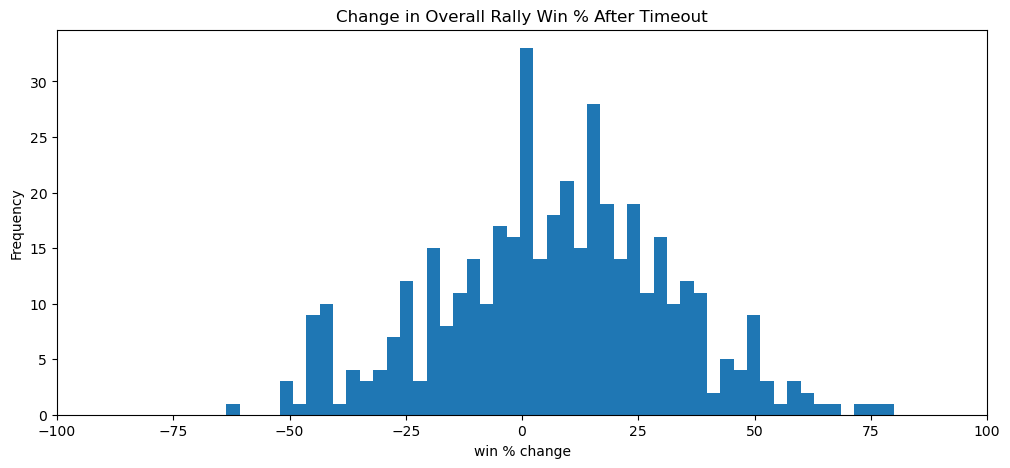

In [133]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=50)
plt.gca().set(title='Change in Overall Rally Win % After Timeout',xlim=[-100,100], xlabel = 'win % change', ylabel='Frequency');

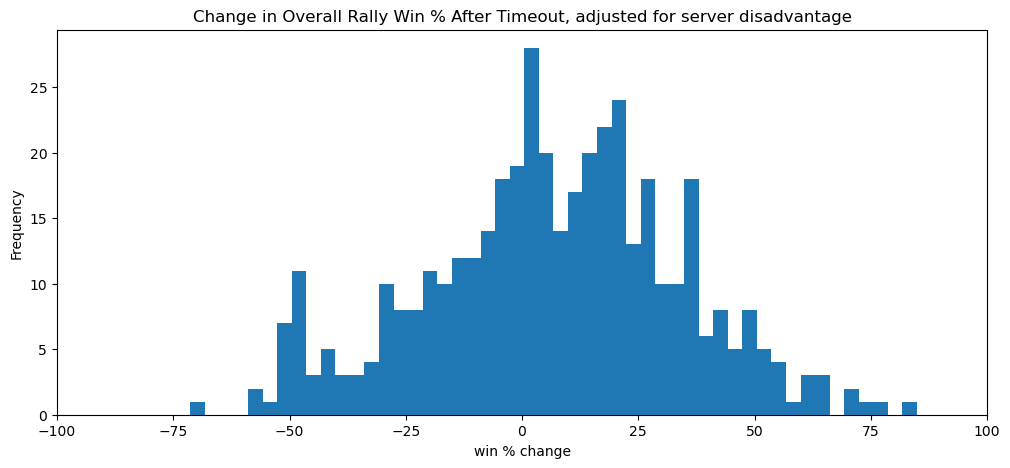

In [134]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin_adj, bins=50)
plt.gca().set(title='Change in Overall Rally Win % After Timeout, adjusted for server disadvantage',xlim=[-100,100], xlabel = 'win % change', ylabel='Frequency');

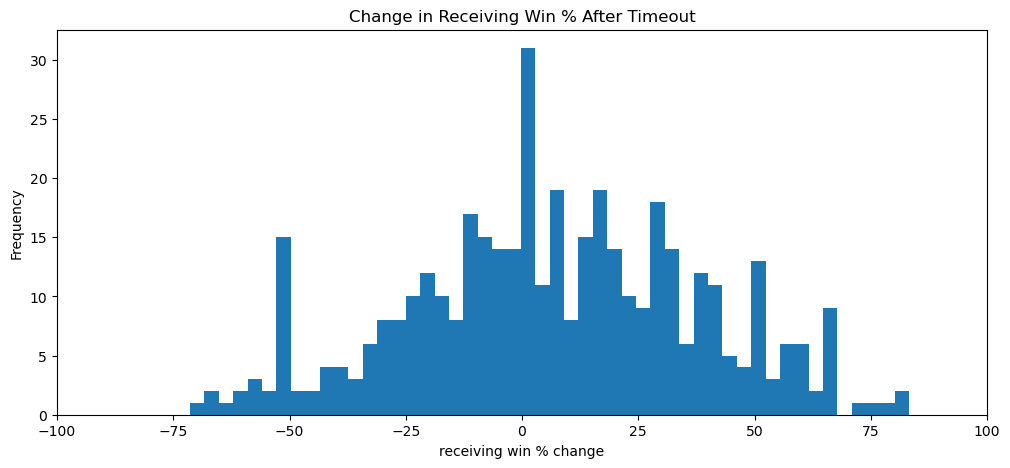

In [135]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinrcv, bins=50)
plt.gca().set(title='Change in Receiving Win % After Timeout', xlim=[-100,100],xlabel = 'receiving win % change', ylabel='Frequency');

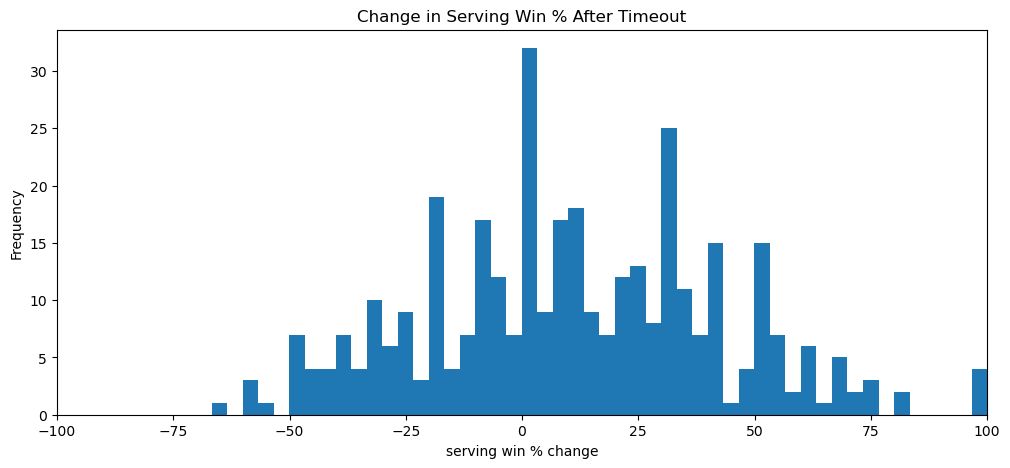

In [136]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinsrv, bins=50)
plt.gca().set(title='Change in Serving Win % After Timeout', xlim=[-100,100],xlabel = 'serving win % change', ylabel='Frequency');

## Group plots by skill level

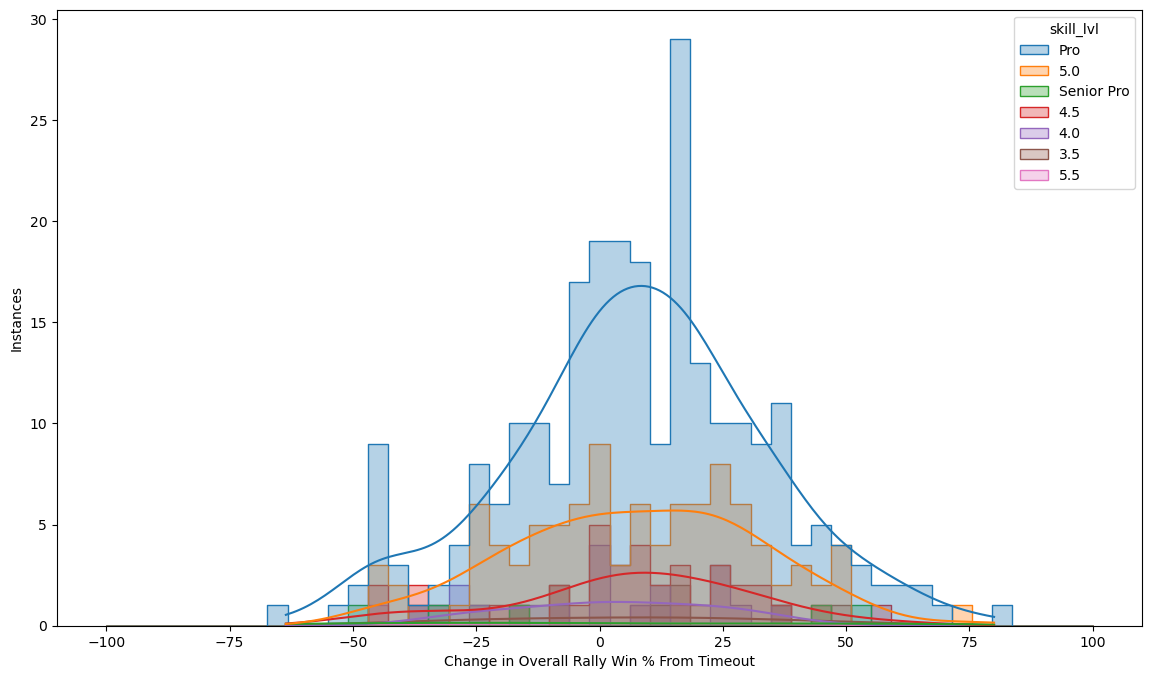

In [137]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Overall Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

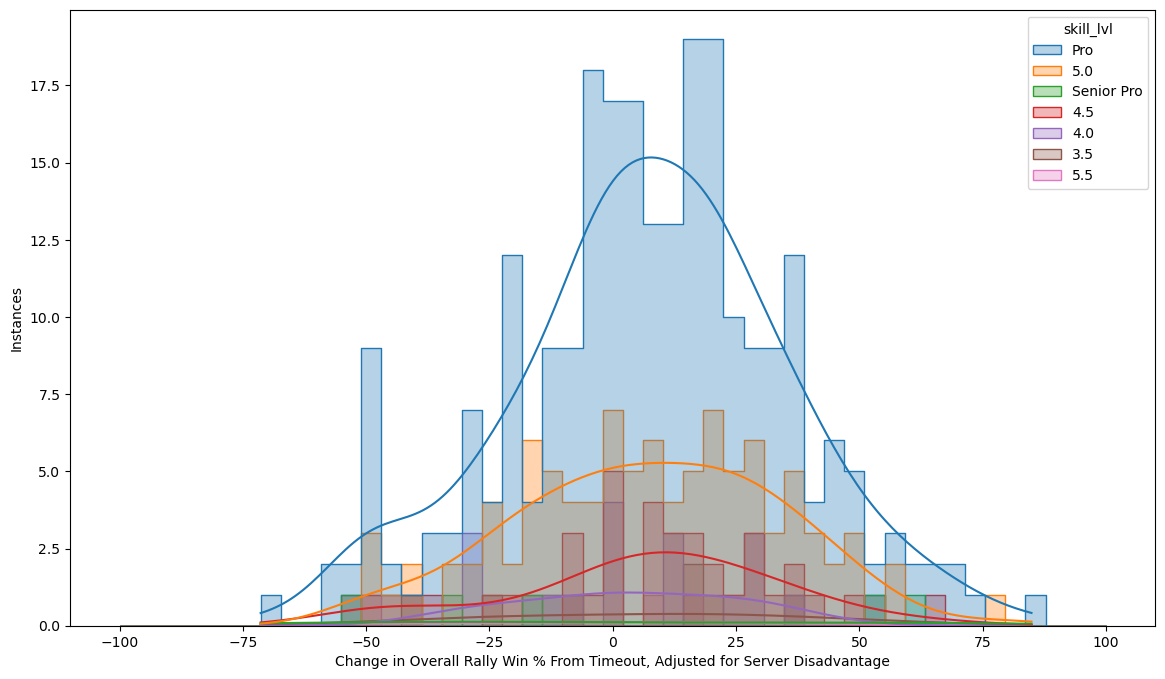

In [138]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawin_adj",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Overall Rally Win % From Timeout, Adjusted for Server Disadvantage",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

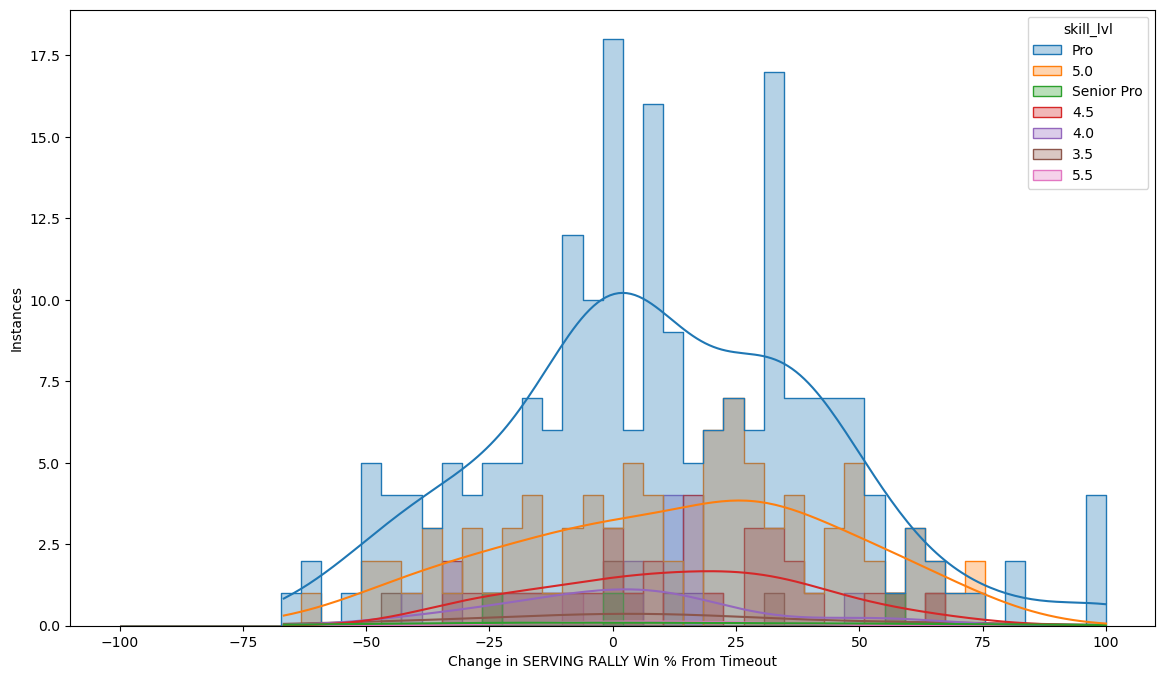

In [139]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinsrv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in SERVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

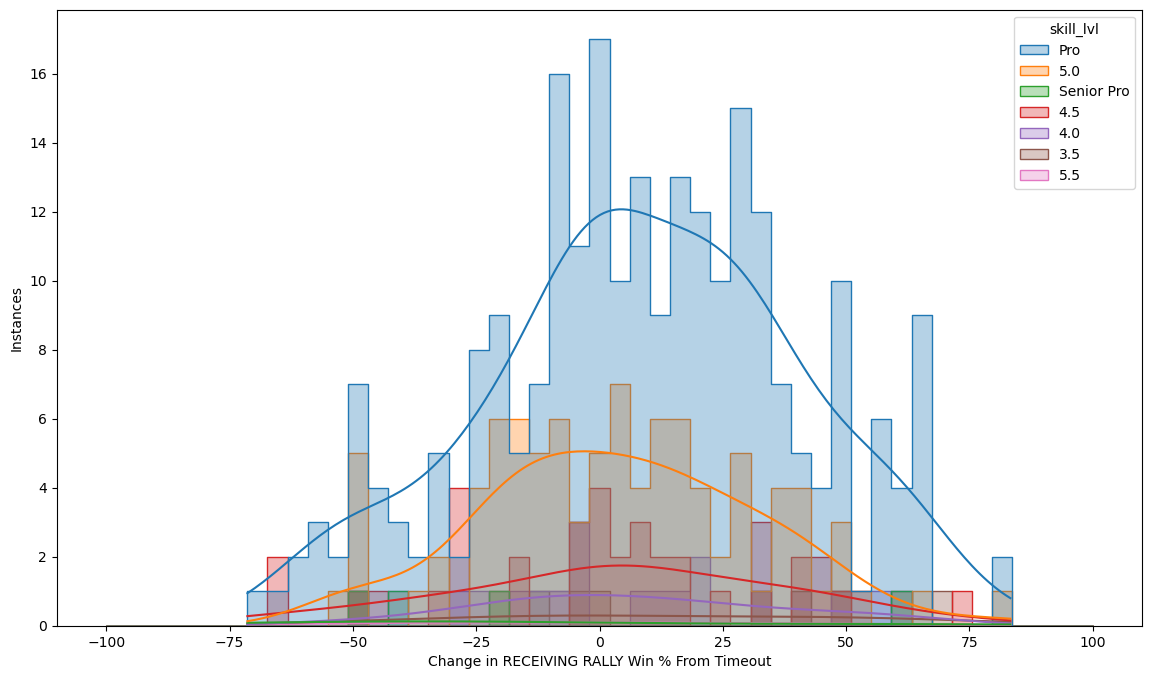

In [140]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinrcv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in RECEIVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

In [141]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_senpro=df_timeout[df_timeout.skill_lvl == 'Senior Pro']
df_35=df_timeout[df_timeout.skill_lvl == '3.5']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
df_55=df_timeout[df_timeout.skill_lvl == '5.5']
skilldata=[list(x.deltawin) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldata_adj=[list(x.deltawin_adj) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatasrv=[list(x['deltawinsrv'][~pd.isna(x.deltawinsrv)]) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatarcv=[list(x['deltawinrcv'][~pd.isna(x.deltawinrcv)] )for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]

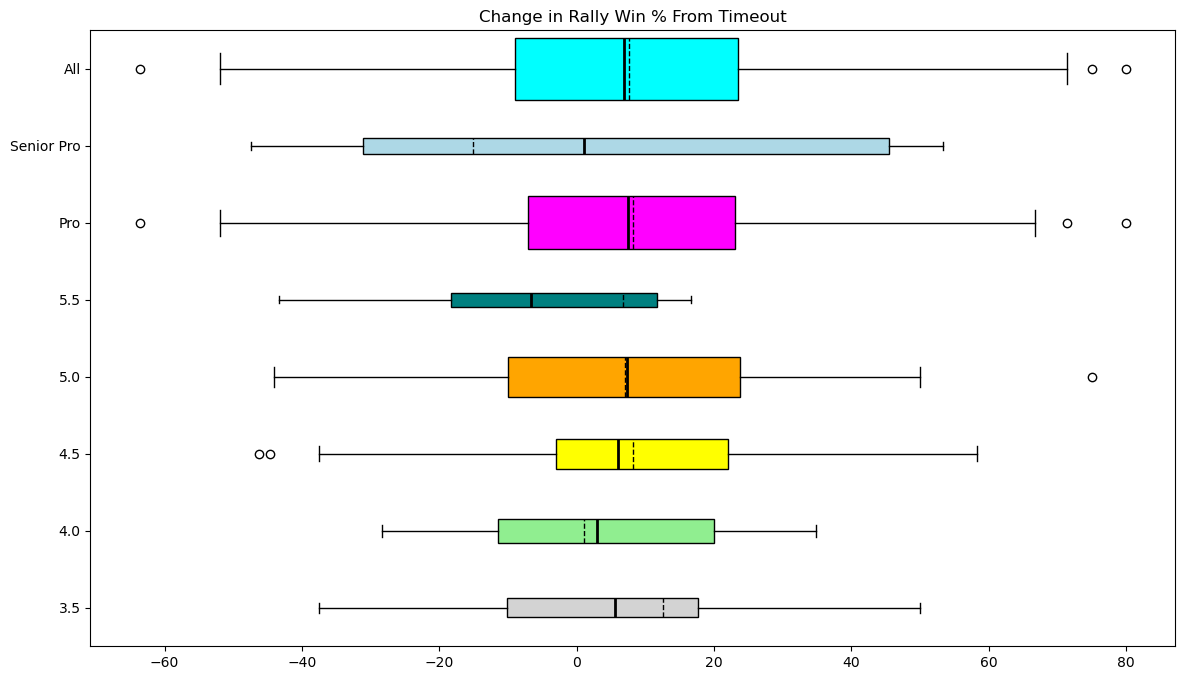

In [142]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in Rally Win % From Timeout")
# Define widths for boxplots as 0.8 of the normalized sample size
sample_sizes=[len(skilldata[x]) for x in range(len(skilldata))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldata,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

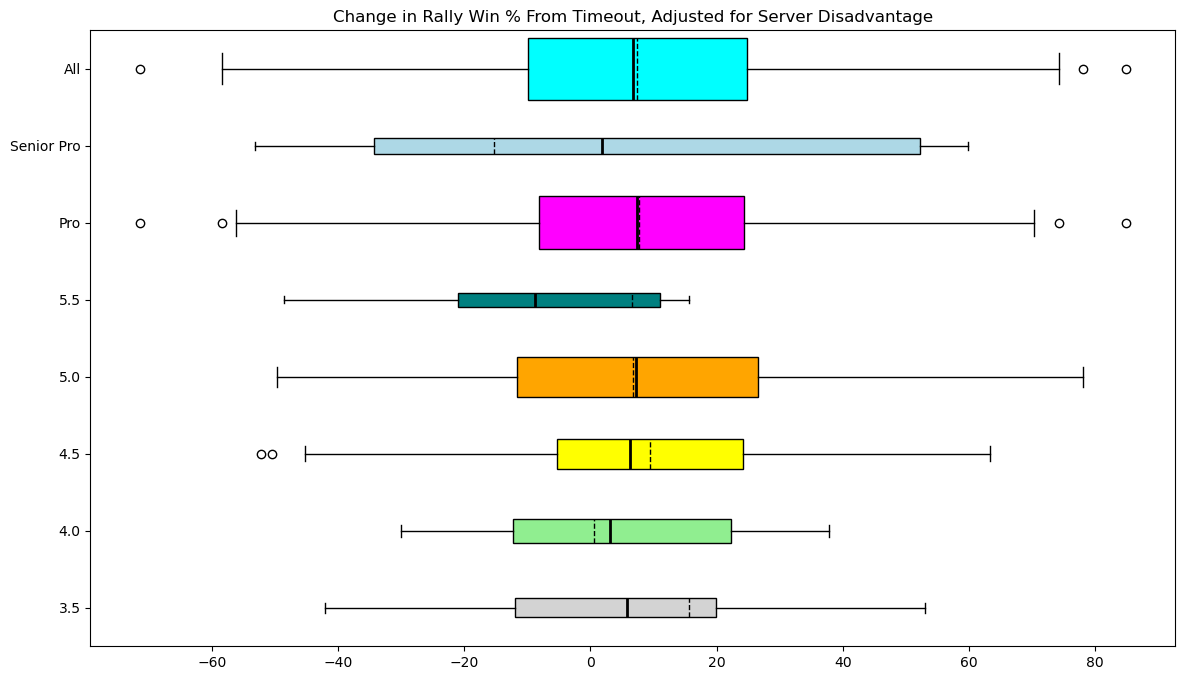

In [143]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in Rally Win % From Timeout, Adjusted for Server Disadvantage")
# Define widths for boxplots as 0.8 of the normalized sample size
sample_sizes=[len(skilldata_adj[x]) for x in range(len(skilldata_adj))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldata_adj,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

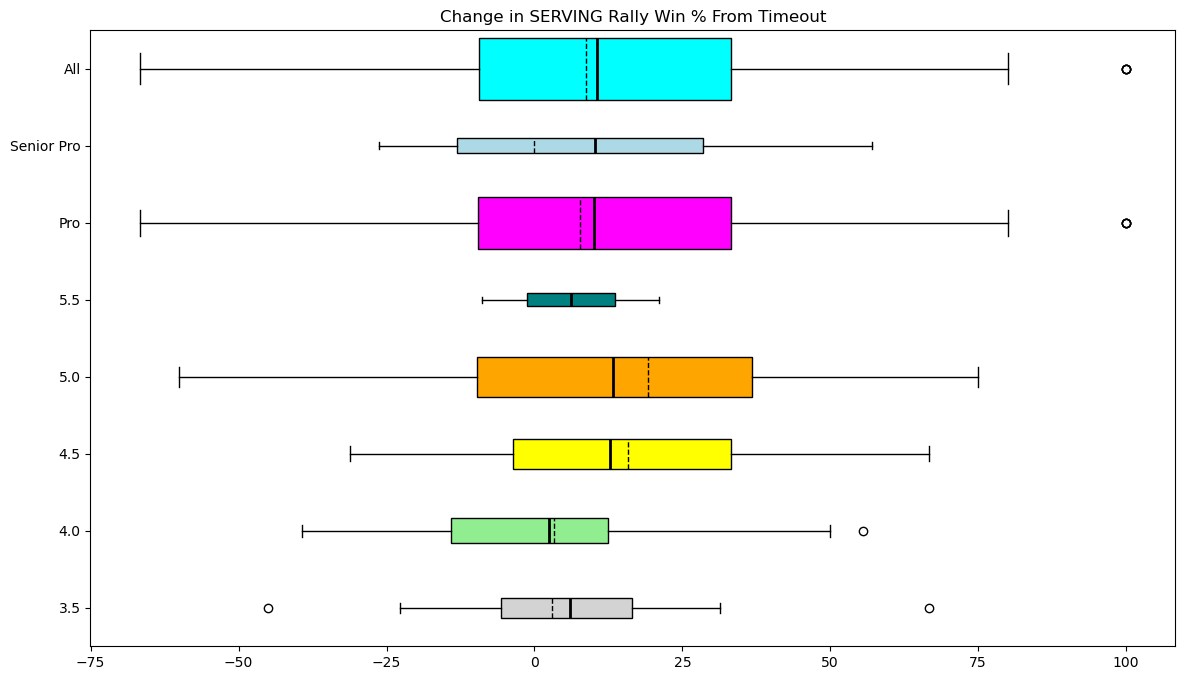

In [144]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in SERVING Rally Win % From Timeout")
sample_sizes=[len(skilldatasrv[x]) for x in range(len(skilldatasrv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatasrv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

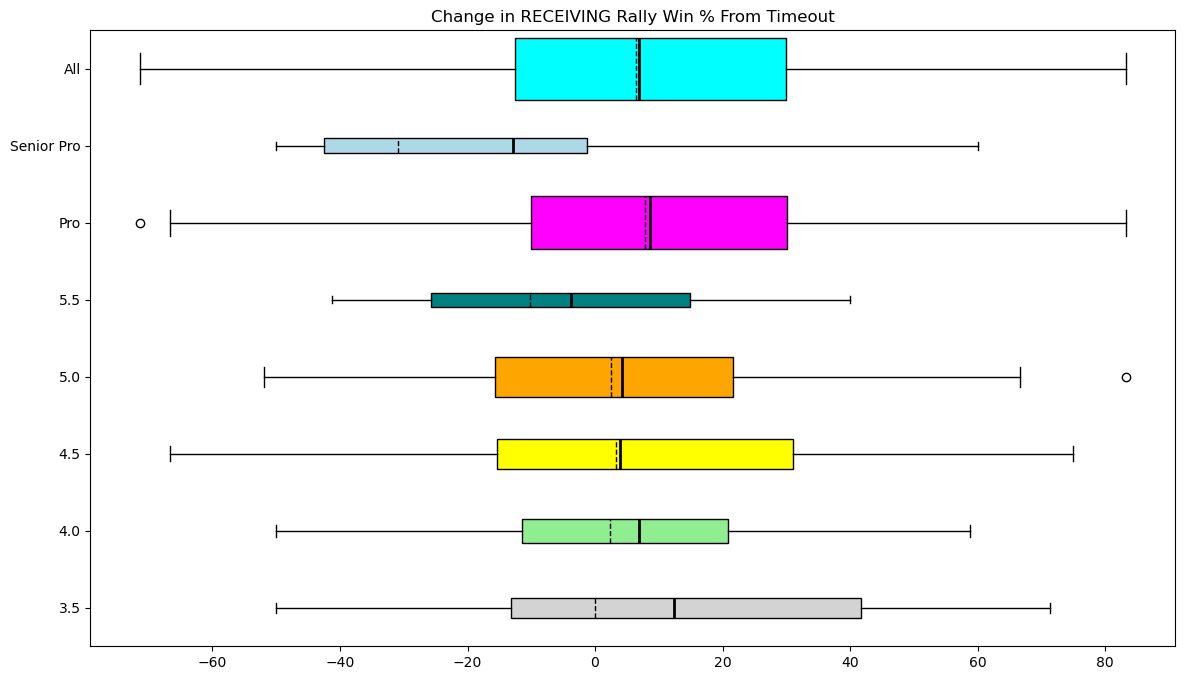

In [145]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in RECEIVING Rally Win % From Timeout")
sample_sizes=[len(skilldatarcv[x]) for x in range(len(skilldatarcv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatarcv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()